# Modelos LSTM

## 1. Introducción a LSTM

LSTM es un acrónimo de *Long-Short Term Memory* y representa a un **subtipo de RNN** (*Recurrent Neural Network*) capaz de **retener información relevante** sobre datos ya procesados que ayude al procesamiento de nuevas secuencias de datos completas. Su arquitectura se encuentra compuesta a su vez por tres redes neuronales:

* ***Forget Gate***: este primer modelo es el encargado de filtrar qué información previa es útil para su almacenamiento y qué datos ya no son útiles para futuras iteraciones. 

* ***Input Gate***: esta segunda red trata de determinar el valor que presentan los datos entrantes para resolver la tarea de clasificación.

* ***Output Gate***: finalmente esta red calcula las salidas del modelo LSTM que dependerán de la tarea de clasificación que se pretende abordar.

### 1.1. Introducción a BiLSTM

Se trata de una variante de la arquitectura compuesta por **dos redes LSTM independientes** con el objetivo de procesar los textos de derecha a izquierda y viceversa. Esta característica permite la **extracción de características en ambos sentidos** proporcionando un **contexto más voluminoso y preciso** al considerar los **términos precedores y sucesores**, almacenando así información pasada y futura del texto. Así, generalmente las redes BiLSTM tienden a mejorar el rendimiento y su capacidad preditiva.

### 1.2. Condiciones de uso

Dependiendo del framework que se pretenda utilizar (Tensorflow, Keras, Pytorch) existen diferentes tratamientos de datos y requisitos de implementación que se deben cumplir al definir la arquitectura, entrenamiento y validación de modelos. En mi caso particular he optado por utilizar **Keras** debido a la experiencia previa que tengo con la librería y a su facilidad de uso. 

1. **Procesamiento y limpieza** de los documentos.

2. **Tokenización** de los documentos especificando un token para aquellos términos que no sean reconocidos dentro de un vocabulario de palabras.

3. **Codificación** numérica en forma de matrices secuenciales de valores. 

5. **Normalización** de las secuencias numéricas para establecer un mismo **tamaño fijo**, completando con ceros aquellas de menor longitud y separando en varias secuencias aquellas que dispongan de un mayor tamaño.

6. Definición de la arquitectura de un **modelo** e instanciación para su posterior entrenamiento y validación.

### 1.3. Casos de uso

* Detección y extracción de patrones en secuencias de datos.
* Modelado del lenguaje natural.
* Traducción de texto.
* Reconocimiento de textos manuscritos.
* Generación de imágenes mediante mecanismos de atención.
* Sistemas de preguntas y respuestas.
* Conversión de vídeo a texto.

## 2. Estructura del notebook

1. Introducción a LSTM
2. Estructura del notebook
3. Instalación y carga de librerías
4. Lectura y carga de datos
5. Experimentos y modelos
6. Conclusiones

## 3. Instalación y carga de librerías

Este apartado tiene como único propósito cargar las librerías y dependencias necesarias para la ejecución de este notebook, así como las funciones propiamente desarrolladas. Previo a ello deberán ser instaladas bien ejecutando el script *setup.sh* mediante el comando `bash setup.sh` con permisos de ejecución en distribuciones Linux, o bien ejecutando el compando `pip install -r requirements.txt`.

In [1]:
%%capture
# pandas: to read the datasets
import pandas as pd

# numpy: to work with Numpy ndarrays
import numpy as np

# keras: to load pre-trained models
from keras.utils import pad_sequences
from keras.models import Model, load_model
from keras.preprocessing.text import Tokenizer

# sklearn: to plot a confusion matrix per trained model
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

# matplotlib: to plot charts
import matplotlib.pyplot as plt
 
import sys
sys.path.append('../scripts')

# data: to analyze test predictions
from data import analyze_predicted_probs, map_texts_to_emotions

2023-05-06 12:15:38.639054: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-06 12:15:39.082893: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-06 12:15:39.082911: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-06 12:15:40.271944: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## 4. Lectura y carga de datos procesados

En esta sección se pretende leer y cargar los datos de entrenamiento y test ya procesados a los que se les ha aplicado las siguientes técnicas de tratamiento de documentos:

  - Elimina URLs.
  - Elimina usuarios mencionados.
  - Elimina caracteres especiales, no alfabéticos y signos de puntuación.
  - Convierte todos los caracteres en minúsculas.
  - **No se aplica lematización** puesto que el rendimiento del modelo apenas mejora aunque el tiempo invertido se multiplica exponencialmente.
  - **No se intenta detectar y corregir palabras erróneamente escritas** puesto que tampoco mejora el rendimiento del modelo pero la inversión de recursos es desorbitada. Según he podido comprobar apenas se detecta un 9,43% de términos con faltas de ortogragía y solo un 7,61% son corregidos, por lo que esta técnica no parece que vaya a ser de utilidad. </p>

Tal y como se puede comprobar en los siguientes resultados las dimensiones de sendos conjuntos de datos se detallan a continuación:

* Conjunto de entrenamiento: **6.865 muestras**.
* Conjunto de validación: **4.296 muestras**.

In [2]:
# Read already processed EXIST datasets
train_df = pd.read_csv('../data/proc_EXIST2021_train.csv')
test_df = pd.read_csv('../data/proc_EXIST2021_test.csv')

# Show the dimensions of the datasets
print('Train dataset dimensions:', train_df.shape)
print('Test dataset dimensions:', test_df.shape)

Train dataset dimensions: (6865, 6)
Test dataset dimensions: (4296, 6)


## 5. Experimentos y modelos

En esta sección se pretende ejemplificar la mejor configuración obtenida en relación a la combinación de distintas técnicas de procesamiento de textos, codificación de documentos y arquitecturas LSTM/BiLSTM, como modelos de Aprendizaje Automático avanzados. A diferencia de los clasificadores entrenados con Regresión Logística, los experimentos efectuados con LSTM/BiLSTM **no son determinísticos**. Como consecuencia, para evaluar el impacto de las modificaciones realizadas sobre los datasets y las arquitecturas se ejecutan **30 iteraciones de cada experimento** para luego calcular la **media de accuracy y AUC**, como métricas de evaluación seleccionadas para medir la calidad de un clasificador. Para más detalles se puede consultar [este notebook](https://github.com/lidiasm/DATCOM-TFM/blob/main/notebooks/run_lstm_experiments.ipynb) donde se encuentra codificado el procedimiento descrito.

Tal y como se explica en ambas competiciones, se realiza una **distinción entre textos en inglés y español** puesto que parece ser que estos últimos se caracterizan por una mejor representación y por ende, los **clasificadores entrenados únicamente sobre documentos españoles demuestran una mayor capacidad de predicción**.

Previo al comienzo de la experimentación se definen las siguientes tres funciones con las que transformar los conjuntos de datos ya procesados en matrices numéricas con las que generar la matriz de embeddings y evaluar los modelos ya entrenados sobre sendos datasets con el objetivo de posteriormente analizar los resultados.

In [3]:
def encode_data_as_matrixes(train_texts:list, test_texts: list, max_n_words: int, sequence_len: int):
    '''
    Function that creates and trains a Keras tokenizer based on the provided
    train documents to encode the train and test data as numeric matrixes.

    Parameters
    ----------
    train_texts : list
        A list of strings with the train documents to encode.
    test_texts : list
        A list of strings with the test documents to encode.
    max_n_words : int
        Maximum number of words to keep within the LSTM memory
        based on computing the word frequency.
    sequence_len : int
        Maximum lenght of all sequences.
    
    Returns
    -------
    A
    '''
    # Create a tokenizer based on train texts
    tokenizer = Tokenizer(num_words=max_n_words)
    tokenizer.fit_on_texts(train_texts)

    # Transform each text into a numeric sequence
    train_sequences = tokenizer.texts_to_sequences(train_texts)

    # Transform each numeric sequence into a 2D vector
    train_matrix = pad_sequences(
        sequences=train_sequences, 
        maxlen=sequence_len)

    # Tokenize the test documents using the prior trained tokenizer
    test_sequences = tokenizer.texts_to_sequences(test_texts)

    # Transform each numeric sequence into a 2D vector
    test_matrix = pad_sequences(
        sequences=test_sequences,
        maxlen=sequence_len)
    
    return tokenizer, train_matrix, test_matrix

In [4]:
def get_embedding_matrix(embedding_file: str, tokenizer: Tokenizer, sequence_len: int):
    '''
    Load the embeddings stored in the provided file to then
    create a matrix with the numeric encoding of each
    available word within the tokenizer vocabulary.

    Parameters
    ----------
    embedding_file : str
        The path to the file which contains a set of embeddings
    tokenizer : Tokenizer (Keras)
        A trained Keras tokenizer which contains the vocabulary
        of the documents to use during the training of models
    sequence_len : int
        Maximum lenght of all embeddings.

    Returns
    -------
    A Numpy ndarray which represents an embedding matrix.
    '''
    # Load the embeddings stored in a TXT file
    embedding_file = open(embedding_file)

    # Store each word with its embeddings
    embeddings_index = {
        line.split()[0]:np.asarray(line.split()[1:], dtype='float32') 
        for line in embedding_file
    }

    # Initialize the embedding matrix with zeros
    embedding_matrix = np.zeros(shape=(len(tokenizer.word_index)+1, sequence_len))

    # Complete the matrix with the prior loaded embeddings
    for word, i in tokenizer.word_index.items():
        # Search for the embeddings of each word
        embedding_vector = embeddings_index.get(word)

        # Words not found will be zeros
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix 

In [10]:
def validate_lstm_model(
    model: Model, 
    train_matrix: np.ndarray, train_labels: list, 
    test_matrix: np.ndarray, test_labels: list):
    '''
    Evaluates the provided trained LSTM model over the 
    train and test datasets to get the accuracy, AUC and
    a confusion matrix. To create the predictions for a
    binary classification a threshold has been set:
        - <= 0.5 represents the negative class (non-sexist).
        - > 0.5 represents the positive class (sexist).

    Parameters
    ----------
    model : Keras model
        A trained Keras model to be evaluated.
    train_matrix : Numpy ndarray
        A numeric sequence matrix with the trained documents.
    train_labels : list
        A numeric list with the class labels of the train dataset.
    test_matrix : Numpy ndarray
        A numeric sequence matrix with the test documents.
    test_labels : list
        A numeric list with the class labels of the test dataset.
    '''
    # Compute and print the accuracy and AUC over train
    train_acc = model.evaluate(
        x=train_matrix, 
        y=np.array(train_labels))

    print(f'Train accuracy: {train_acc[1]}')
    print(f'Train AUC: {train_acc[2]}\n')

    # Compute and print the accuracy and AUC over test
    test_acc = model.evaluate(
        x=test_matrix, 
        y=np.array(test_labels))

    print(f'Test accuracy: {test_acc[1]}')
    print(f'Test AUC: {test_acc[2]}')

    # Generate class label predictions over the test dataset
    test_preds = (model.predict(test_matrix) >= 0.5).astype('int32')

    # Plot the confusion matrix 
    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(
            np.array(test_labels), 
            np.array(test_preds)), 
        display_labels=['Non-sexist', 'Sexist']) \
    .plot(cmap='Blues')

### 5.1. Modelo específico para inglés

* **Codificación de textos mediante embeddings**. Tras experimentar con diferentes ficheros situados en el siguiente [enlace](https://nlp.stanford.edu/projects/glove/), por ser **multilenguaje**, estar basado en un **mayor número de vocabulario** y por proporcionar un buen balance entre el rendimiento de los modelos y la inversión de recursos necesarios, he seleccionado el archivo **glove.twitter.27B.100d.txt**.

* **Arquitectura e hiperparámetros**.
  * 1 capa de entrada para proporcionar los documentos procesados.
  * **2 capas ocultas bidireccionales con 128 neuronas** cada una.
  * 1 capa de salida con la que asignar una clase a cada muestra.
  * **Tamaño del lote: 32**.
  * <p>Máximo número de palabras que se mantienen en memoria: 1.000.</p>

* **Entrenamiento y validación**.
  * Número máximo de **iteraciones**: 100.
  * **Early Stopping** tras 15 iteraciones sin una mejora mayor que 0.01 en el valor de la métrica *AUC* en validación y recuperando los pesos del mejor modelo encontrado. 
  * Porcentaje de **validación**: 20%.
  * Función de pérdida: *binary_crossentropy*.
  * Optimizador: Adam.
  * **Métricas de validación**: *accuracy* y AUC.

Tal y como se puede apreciar en los siguientes resultados, la tasa de aciertos sobre el conjunto de entrenamiento apenas alcanza un 78% mientras que sobre **test únicamente existe un 70% de accuracy**. Parece que esta diferencia no es demasiado notable como para detectar cierto *overfitting* y observando el área bajo la curva ROC del conjunto de test se puede determinar que el modelo **no dispone de una buena capacidad de predicción**. 

Observando la matriz de confusión es altamente notable la **elevada tasa de falsos negativos**, es decir, textos sexistas que no han sido detectados. Por lo tanto una arquitectura LSTM y la mejor configuración encontrada en este grupo de experimentos, parece no ser suficiente precisa como para construir un clasificador de calidad capaz de identificar textos sexistas y no sexistas.

107/107 [==============================] - 8s 64ms/step - loss: 0.4713 - accuracy: 0.7778 - auc: 0.8626
Train accuracy: 0.7777777910232544
Train AUC: 0.8626314997673035

69/69 [==============================] - 5s 79ms/step - loss: 0.6212 - accuracy: 0.7042 - auc: 0.7715
Test accuracy: 0.7041800618171692
Test AUC: 0.771522581577301
69/69 [==============================] - 5s 59ms/step


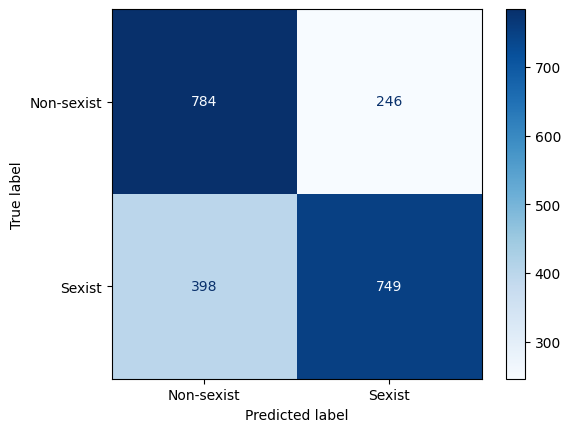

In [12]:
# Number of words to retain in the LSTM memory
MAX_N_WORDS = 1000

# Max number of tokens per numeric sequence
SEQUENCE_MAX_LEN = 100

# Path to the multilanguage embedding file
MULTILAN_EMBEDDINGS_FILE = '../en_es_embeddings/glove.twitter.27B.100d.txt'

# Filter train and test texts by language
en_train_df = train_df[train_df['language'] == 'en']
en_test_df = test_df[test_df['language'] == 'en']

# Convert processed train and test documents into matrixes
en_tokenizer, en_train_matrix, en_test_matrix = encode_data_as_matrixes(
    train_texts=list(en_train_df['clean_text'].values),
    test_texts=list(en_test_df['clean_text'].values),
    max_n_words=MAX_N_WORDS,
    sequence_len=SEQUENCE_MAX_LEN
)

# Get the embedding matrix based on the train documents
en_embed_matrix = get_embedding_matrix(
    embedding_file=MULTILAN_EMBEDDINGS_FILE,
    tokenizer=en_tokenizer,
    sequence_len=SEQUENCE_MAX_LEN
)

# Load a pretrained BiLSTM model trained over English texts
en_bilstm_model = load_model('../models/en_lstm_models/en_bilstm_model_2L_128N_32BS.h5')

# Evaluate the model over train and test datasets
validate_lstm_model(
    model=en_bilstm_model,
    train_matrix=en_train_matrix,
    train_labels=list(en_train_df['task1'].values),
    test_matrix=en_test_matrix,
    test_labels=list(en_test_df['task1'].values)
)

#### 5.1.1. Análisis de resultados

Con el propósito de tratar de identificar la existencia de posibles patrones que dificultan la construcción de un clasificador de calidad para detectar textos sexistas y no sexistas, se ha realizado la siguiente experimentación. Consiste en evaluar las **muestras mal clasificadas** de cada categoría a partir de intervalos de confianza para posteriormente cruzar los ejemplos resultantes con el **análisis de emociones y las categorías sexistas** de la columna *task2*, para las muestras de la clase positiva. 

En los siguientes resultados podemos observar cómo la **gran mayoría de falsos negativos han sido clasificados en base a umbrales ínfimos de confianza**, por lo que el modelo no parece estar nada seguro acerca de las decisiones que ha tomado. Esta situación puede ser más beneficiosa puesto que se pueden aplicar técnicas a priori o a posteriori para ayudar a mejorar la clasificación. Sin embargo, el fenómeno contrario ocurre con los **falsos positivos, puesto que la mayoría de estos casos se concentran en los intervalos de confianza más altos**.

In [43]:
# Predict over the test dataset
en_test_probs = (en_bilstm_model.predict(en_test_matrix))
en_test_preds = (en_bilstm_model.predict(en_test_matrix) >= 0.5).astype('int32')

# Insert the predicted classes and probabilities into the test dataset
en_test_df['task1_pred_classes'] = en_test_preds
en_test_df['task1_pred_probs'] = en_test_probs

print('FALSE NEGATIVES')
false_negatives_df = en_test_df[(en_test_df['task1'] == 1) & (en_test_df['task1_pred_classes'] == 0)]
analyze_predicted_probs(
    dataset=false_negatives_df,
    probs_col='task1_pred_probs')

print('\nFALSE POSITIVES')
false_positives_df = en_test_df[(en_test_df['task1'] == 0) & (en_test_df['task1_pred_classes'] == 1)]
analyze_predicted_probs(
    dataset=false_positives_df,
    probs_col='task1_pred_probs')

69/69 [==============================] - 4s 64ms/step
FALSE NEGATIVES
Confidence Interval Very low (0.0, 0.2): 182 samples
Confidence Interval Low (0.2, 0.4): 123 samples
Confidence Interval Medium (0.4, 0.6): 93 samples
Confidence Interval High (0.6, 0.8): 0 samples
Confidence Interval Very high (0.8, 1.0): 0 samples

FALSE POSITIVES
Confidence Interval Very low (0.0, 0.2): 0 samples
Confidence Interval Low (0.2, 0.4): 0 samples
Confidence Interval Medium (0.4, 0.6): 69 samples
Confidence Interval High (0.6, 0.8): 123 samples
Confidence Interval Very high (0.8, 1.0): 54 samples


/tmp/ipykernel_11892/1470426946.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_test_df['task1_pred_classes'] = en_test_preds
/tmp/ipykernel_11892/1470426946.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_test_df['task1_pred_probs'] = en_test_probs


Si se cruzan las muestras positivas erróneamente clasificadas con las categorías sexistas a las que pertenecen se observa una tendencia idéntica a la vista en el entrenamiento y validación de modelos con Regresión Logística. La **mayoría de los documentos sexistas pertenecen a categorías sumamente complicadas de detectar** por clasificadores automáticos debido a su falta de características concretas que permitan asimilar su patrón.

In [44]:
false_negatives_df.groupby(['task2']).count().filter(['id']).sort_values(by=['id'], ascending=False)

,id
task2,
ideological-inequality,121
stereotyping-dominance,96
misogyny-non-sexual-violence,86
sexual-violence,56
objectification,39


Finalmente combinando los falsos positivos y negativos con el análisis de detección de emociones realizado se descubren dos principales emociones que aglutinan la mayoría de documentos erróneamente clasificados: ***anger*** y ***joy***. Tras una inspección visual de nuevo he podido encontrar conclusiones similares a las alcanzadas con los modelos de Regresión Logística, siendo un **alto porcentaje de documentos irónicos los predominantes en la emoción *anger*, mientras que los textos clasificados en la emoción *joy* contienen terminología positiva mayoritariamente aunque sus significados son muy negativos y sexistas**.

In [45]:
print('FALSE NEGATIVES')
map_texts_to_emotions(
    text_ids=list(false_negatives_df['id'].values),
    is_test=True
)

print('\nFALSE POSITIVES')
map_texts_to_emotions(
    text_ids=list(false_positives_df['id'].values),
    is_test=True
)

FALSE NEGATIVES
Emotion: fear - No. of texts: 36
Emotion: surprise - No. of texts: 7
Emotion: joy - No. of texts: 97
Emotion: love - No. of texts: 6
Emotion: anger - No. of texts: 186
Emotion: sadness - No. of texts: 66

FALSE POSITIVES
Emotion: fear - No. of texts: 30
Emotion: surprise - No. of texts: 5
Emotion: joy - No. of texts: 76
Emotion: love - No. of texts: 2
Emotion: anger - No. of texts: 107
Emotion: sadness - No. of texts: 26


### 5.2. Modelo específico para español

La configuración de datos y embeddings es idéntica a la utilizada para el clasificador sobre textos en inglés, al igual que los parámetros de entrenamiento y validación. La única diferencia que reside entre sendos modelos es la arquitectura aplicada a este caso, que se detalla a continuación:

* **Arquitectura e hiperparámetros**.
  * 1 capa de entrada para proporcionar los documentos procesados.
  * **3 capas ocultas unidireccionales con 128, 64 y 32 neuronas**.
  * 1 capa de salida con la que asignar una clase a cada muestra.
  * **Tamaño del lote: 16**.
  * <p>Máximo número de palabras que se mantienen en memoria: 1.000.</p>

En los siguientes resultados se visualiza una tasa de aciertos sobre el conjunto de **entrenamiento del 74% y sobre test del 71%**, cifras bastante similares a las del modelo específico de documentos en inglés. Por lo tanto, utilizando las configuraciones de datos, embeddings y modelos descritas **no parece mejorar la capacidad de predicción del clasificador español**, y tampoco aparece el fenómeno destacado en los resúmenes de las competiciones en el que se afirmaba una mejor representatividad de los textos españoles. 

La matriz de confusión es muy similar a la apreciada anteriormente con una **alta tasa de falsos negativos**, es decir, textos sexistas no identificados como tal. Por lo tanto este modelo tampoco parece ser suficientemente preciso para discernir entre sendas clases adecuadamente.

109/109 [==============================] - 4s 33ms/step - loss: 0.5428 - accuracy: 0.7405 - auc: 0.8047
Train accuracy: 0.7404953837394714
Train AUC: 0.804656982421875

67/67 [==============================] - 2s 33ms/step - loss: 0.5801 - accuracy: 0.7159 - auc: 0.7764
Test accuracy: 0.7159036993980408
Test AUC: 0.7764281034469604
67/67 [==============================] - 3s 34ms/step


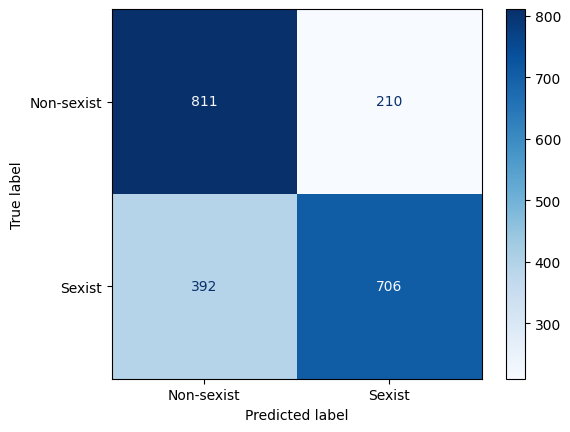

In [13]:
# Filter train and test texts by language
es_train_df = train_df[train_df['language'] == 'es']
es_test_df = test_df[test_df['language'] == 'es']

# Convert processed train and test documents into matrixes
es_tokenizer, es_train_matrix, es_test_matrix = encode_data_as_matrixes(
    train_texts=list(es_train_df['clean_text'].values),
    test_texts=list(es_test_df['clean_text'].values),
    max_n_words=MAX_N_WORDS,
    sequence_len=SEQUENCE_MAX_LEN
)

# Get the embedding matrix based on the train documents
es_embed_matrix = get_embedding_matrix(
    embedding_file=MULTILAN_EMBEDDINGS_FILE,
    tokenizer=es_tokenizer,
    sequence_len=SEQUENCE_MAX_LEN
)

# Load a pretrained BiLSTM model trained over Spanish texts
es_lstm_model = load_model('../models/es_lstm_models/es_lstm_3L_1286432N_16BS.h5')

# Evaluate the model over train and test datasets
validate_lstm_model(
    model=es_lstm_model,
    train_matrix=es_train_matrix,
    train_labels=list(es_train_df['task1'].values),
    test_matrix=es_test_matrix,
    test_labels=list(es_test_df['task1'].values)
)

#### 5.2.1. Análisis de resultados

Se replican los estudios realizados préviamente aunque con los resultados y predicciones elaboradas por el clasificador basado en documentos españoles.

De nuevo en el primer análisis sobre los intervalos de confianza de las muestras erróneamente clasificadas, se descubre una tendencia similar a la anteriormente visualizada. **La gran mayoría de falsos negativos se distribuyen en los intervalos de confianza más bajos, mientras que ocurre lo contrario con los falsos positivos**. De nuevo el modelo no muestra la misma seguridad al equivocarse en clasificar las muestras positivas y negativas, respectivamente, siendo la clase sexista en la que demuestra una alta predisposición a dudas.

In [48]:
# Predict over the test dataset
es_test_probs = (es_lstm_model.predict(es_test_matrix))
es_test_preds = (es_lstm_model.predict(es_test_matrix) >= 0.5).astype('int32')

# Insert the predicted classes and probabilities into the test dataset
es_test_df['task1_pred_classes'] = es_test_preds
es_test_df['task1_pred_probs'] = es_test_probs

print('FALSE NEGATIVES')
false_negatives_df = es_test_df[(es_test_df['task1'] == 1) & (es_test_df['task1_pred_classes'] == 0)]
analyze_predicted_probs(
    dataset=false_negatives_df,
    probs_col='task1_pred_probs')

print('\nFALSE POSITIVES')
false_positives_df = es_test_df[(es_test_df['task1'] == 0) & (es_test_df['task1_pred_classes'] == 1)]
analyze_predicted_probs(
    dataset=false_positives_df,
    probs_col='task1_pred_probs')

67/67 [==============================] - 2s 32ms/step
FALSE NEGATIVES
Confidence Interval Very low (0.0, 0.2): 78 samples
Confidence Interval Low (0.2, 0.4): 232 samples
Confidence Interval Medium (0.4, 0.6): 82 samples
Confidence Interval High (0.6, 0.8): 0 samples
Confidence Interval Very high (0.8, 1.0): 0 samples

FALSE POSITIVES
Confidence Interval Very low (0.0, 0.2): 0 samples
Confidence Interval Low (0.2, 0.4): 0 samples
Confidence Interval Medium (0.4, 0.6): 86 samples
Confidence Interval High (0.6, 0.8): 107 samples
Confidence Interval Very high (0.8, 1.0): 17 samples


/tmp/ipykernel_11892/258339437.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  es_test_df['task1_pred_classes'] = es_test_preds
/tmp/ipykernel_11892/258339437.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  es_test_df['task1_pred_probs'] = es_test_probs


Cruzando los falsos negativos con las categorías sexistas disponibles en el dataset de test, se aprecia una tendencia diferente en la que en primera posición se situa una clase caracterizada por documentos relativos a **reivindicaciones en contra de personas que han cometido violencia sexual** contra mujeres, con **faltas de ortografía y hashtags** que dificultan su codificación a embeddings por lo que se pierde información y contexto, así como textos con **terminología positiva** aunque una fuerte connotación sexista. El resto de categorías según inspecciones visuales previas comparten las dos últimas características además de tratar de otros tópicos, como el racismo. En resumen, este ranking demuestra que efectivamente existe una **representación distinta entre textos españoles e ingleses**.

In [49]:
false_negatives_df.groupby(['task2']).count().filter(['id']).sort_values(by=['id'], ascending=False)

,id
task2,
sexual-violence,104
misogyny-non-sexual-violence,87
ideological-inequality,76
stereotyping-dominance,63
objectification,62


Por último si se añaden las emociones detectadas durante el análisis exploratorio de datos de test, podemos visualizar que la **gran mayoría de documentos pertenecientes a falsos negativos y positivos siguen caracterizándose por la emocion *joy***, por lo tanto contienen términos positivos aunque significados profundamente sexistas y nada acordes a la igualdad de género.

In [50]:
print('FALSE NEGATIVES')
map_texts_to_emotions(
    text_ids=list(false_negatives_df['id'].values),
    is_test=True
)

print('\nFALSE POSITIVES')
map_texts_to_emotions(
    text_ids=list(false_positives_df['id'].values),
    is_test=True
)

FALSE NEGATIVES
Emotion: fear - No. of texts: 103
Emotion: anger - No. of texts: 132
Emotion: sadness - No. of texts: 6
Emotion: joy - No. of texts: 151

FALSE POSITIVES
Emotion: fear - No. of texts: 66
Emotion: joy - No. of texts: 100
Emotion: love - No. of texts: 1
Emotion: anger - No. of texts: 39
Emotion: sadness - No. of texts: 4


## 6. Conclusiones de experimentos con LSTM y BiLSTM

### 6.1. Técnicas de procesamiento de textos

  * **La lematización no ha conseguido apenas mejorar** la capacidad predictiva de los modelos aunque sí que aumenta el tiempo y los recursos de computación exponencialmente. Por lo tanto en ninguno de los ejemplos se ha aplicado este tratamiento de textos. 

  * Otra técnica empleada ha sido la **detección y corrección de palabras mal escritas** puesto que las fuentes de datos de las que proceden los documentos son redes sociales y es bien conocido que en estos medios la escritura de textos no es ni precisa ni correcta en la mayoría de ocasiones. Aunque el objetivo era **aumentar el número de palabras codificables** por los *embeddings* incrementando la representatividad de las matrices de entrada a los modelos, **tampoco se ha conseguido incrementar la capacidad de predicción** de los modelos. Analizando las posibles teorías explicativas de este suceso, se han calculado las siguientes métricas para el conjunto de entrenamiento:

    * Número de palabras totales: 201.361
    * Número de términos incorrectos detectados: 19.008
    * Número de términos incorrectos corregidos: 15.341

    Tal y como se puede apreciar **únicamente existe un 10% aproximadamente de términos incorrectos** en los textos de entrenamiento aunque se han corregido más de un 80% de ellos. Dadas estas cifras, parece razonable el hecho de no notar mejoría alguna aplicando esta técnica para el entrenamiento de modelos LSTM.

### 6.2. Embeddings

Tras codificar los documentos de entrenamiento y validación con varios de los ficheros de **embeddings** relativos a este [link](https://nlp.stanford.edu/projects/glove/) utilizando la arquitectura explicada anteriormente, se ha podido determinar que aquellos **embeddings basados en un vocabulario más voluminoso** proporcionan mejores métricas de *accuracy* y AUC por aumentar la representatividad de los textos al **codificar un mayor número de palabras**. 

No obstante no ocurre lo mismo con el **número de vectores**, puesto que los ficheros de 200 y 300 disparan el tiempo de entrenamiento y validación mientras que los valores de las anteriores métricas se mantienen prácticamente invariables con respecto al uso del fichero con únicamente 100 vectores. 

### 6.3. Batch size

En este apartado se destaca la experimentación con diferentes tamaños de lote, siendo los valores más comunes: **128, 64, 32, 16 y 8**. Según los resultados obtenidos **apenas existe diferencia entre los dos primeros** en relación a las métricas de *accuracy* y AUC, invirtiendo un menor número de recursos computacionales en el primer caso. **Sí se ha notado una mejora considerable con los tamaños de lote 32 y 16**, siendo el primero más prolífero para los clasificadores basados en inglés mientras que el segundo valor ha proporcionado resultados con hasta más de un 2% para modelos basados en textos españoles. Por ello han sido los dos tamaños de lote seleccionados para el entrenamiento de cada modelo por idioma.

### 6.5. Configuración de entrenamiento

La inclusión de la técnica **Early Stopping** ha sido **crucial para evitar el *overfitting*** y el malgasto de recursos y tiempo computacional para obtener un modelo con peor calidad a costa de un mayor número de iteraciones. Para su configuración se han probado diferentes métricas como *loss*, *accuracy* y ***AUC***, siendo esta última la elegida por demostrar un **equilibrio entre el tiempo invertido y su capacidad predictiva**, ya que con *accuracy* se conseguían clasificadores muy tempranos recortando considerablemente el número de iteraciones utilizadas para su construcción. 

### 6.6. Data Augmentation

* **Traducción de textos**. Esta primera técnica se ha empleado para aumentar el número de muestras del conjunto de entrenamiento traduciendo los **textos ingleses a español y viceversa**, consiguiendo el doble de documentos. 

* **Easy Data Augmentation**. Conocida como EDA se trata de un conjunto de técnicas con las que se generan nuevos textos añadiendo **sinónimos** de palabras elegidas aleatoriamente, modificando la **posición** de términos de manera aleatoria e incluso **eliminando** conceptos con una cierta probabilidad aleatoria.

* **Round-Trip Translation**. También denominada RTT es una metodología capaz de traducir documentos de su idioma origen a otro especificado para generar nuevos documentos a partir de una **segunda traducción a la inversa** aprovechando las variaciones incluidas en esta fase debido a la interpretación de los traductores. 

* **Contextual Word Embeddings**. Esta técnica emplea modelos de **parafraseo y/o transformers** para generar nuevos textos a partir del **contexto** de las muestras proporcionadas con el objetivo de mantener su significado y así proporcionar un conjunto de documentos más homogeneo.

Si bien se han utilizado diferentes procesos con los que aumentar el conjunto de entrenamiento, no se ha podido descubrir ninguna mejora importante al construir modelos LSTM y BiLSTM.

### 6.7. Arquitecturas

Se han experimentado con diversas arquitecturas añadiendo/eliminando número de neuronas, capas ocultas, combinando capas bidireccionales con unidireccionales, añadiendo capas *drop out*, etc. En base a las distintas pruebas se ha podido confirmar que el **número de capas ocultas más optimizado oscila entre 2 con 128 neuronas cada una y 3 con 128, 64 y 32 neuronas, respectivamente**. Un mayor número de capas y/o de neuronas aumenta los recursos necesarios para la construcción del modelo pero no su capacidad de predicción en términos de accuracy y AUC.

Finalmente existen **muy pocas diferencias entre el uso de capas unidireccionales y bidireccionales**, siendo estas últimas ligeramente mejor con un mayor volumen de datos de entrenamiento o con una arquitectura más compleja en términos de más capas ocultas.